In [1]:
import warnings
warnings.filterwarnings('always')
warnings.filterwarnings('ignore')

In [2]:
import os
import numpy as np
np.random.seed(777)
import math
import keras
import keras.backend as K
import h5py
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam, SGD, RMSprop
from keras.models import Sequential
from keras.models import Model
from keras.layers import Input, Activation, merge, Dense, Flatten, Dropout, concatenate
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.layers import BatchNormalization, add, GlobalAveragePooling2D
from keras.utils.np_utils import to_categorical
from keras.optimizers import Adam
from sklearn.metrics import accuracy_score,roc_curve, confusion_matrix, roc_auc_score, auc, f1_score
from keras.applications import InceptionResNetV2

from keras.layers import Input, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, Lambda,Concatenate
from keras.layers import SeparableConv2D, AveragePooling2D, MaxPooling2D, Dropout, GlobalMaxPooling2D, GlobalAveragePooling2D, Add

import matplotlib.pyplot as plt
%matplotlib inline

plt.rcParams["axes.grid"] = False
plt.rcParams.update({'font.size': 20})

Using TensorFlow backend.


In [3]:
train_dir = 'data-ICIAR/Macenko/train/'
test_dir = "data-ICIAR/Macenko/test/"

extracted_features_dir = "extracted_features/"
model_name = "Macenko_InceptionV4_plain"

In [4]:
import keras
import tensorflow as tf
import keras.backend as K

print("Keras Version", keras.__version__)
print("tensorflow Version", tf.__version__)
print("dim_ordering:", K.image_dim_ordering())

Keras Version 2.2.4
tensorflow Version 1.9.0
dim_ordering: tf


In [5]:
batch_size = 32
img_height, img_width = 512, 512
input_shape = (img_height, img_width, 3)
epochs = 1000

In [6]:
for root,dirs,files in os.walk(train_dir):
    print (root, len(files))

# print("*"*30)
# for root,dirs,files in os.walk(validation_dir):
#     print (root, len(files))
    
print("*"*30)
for root,dirs,files in os.walk(test_dir):
    print (root, len(files))

data-ICIAR/Macenko/train/ 0
data-ICIAR/Macenko/train/Benign 1155
data-ICIAR/Macenko/train/InSitu 1155
data-ICIAR/Macenko/train/Invasive 1155
data-ICIAR/Macenko/train/Normal 1155
******************************
data-ICIAR/Macenko/test/ 0
data-ICIAR/Macenko/test/Benign 25
data-ICIAR/Macenko/test/InSitu 25
data-ICIAR/Macenko/test/Invasive 25
data-ICIAR/Macenko/test/Normal 25


In [7]:
random_seed = np.random.seed(1142)

train_datagen = ImageDataGenerator(
    rescale=1. / 255,
    featurewise_center=True,
    featurewise_std_normalization=True,
    validation_split= 0.25,
    zoom_range=0.2,
    shear_range=0.2)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    seed = random_seed,
    shuffle = False,
    subset = 'training',
    class_mode='categorical')

validation_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    seed = random_seed,
    shuffle = False,
    subset = 'validation',
    class_mode='categorical')

test_datagen = ImageDataGenerator(rescale=1. / 255)
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    seed = random_seed,
    shuffle = False,
    class_mode='categorical')

# test_generator_without_aug = test_datagen.flow_from_directory(
#     test_dir_whithout_aug,
#     target_size=(img_height, img_width),
#     batch_size=batch_size,
#     seed = random_seed,
#     shuffle = False,
#     class_mode='categorical')

Found 3468 images belonging to 4 classes.
Found 1152 images belonging to 4 classes.
Found 100 images belonging to 4 classes.


In [8]:
nb_train_samples = len(train_generator.filenames)
nb_validation_samples = len(validation_generator.filenames)
predict_size_train = int(math.ceil(nb_train_samples / batch_size))
predict_size_validation = int(math.ceil(nb_validation_samples / batch_size))

nb_test_samples = len(test_generator.filenames)
predict_size_test = int(math.ceil(nb_test_samples / batch_size))

# nb_test_without_aug_samples = len(test_generator_without_aug.filenames)
# predict_size_test_without_aug = int(math.ceil(nb_test_without_aug_samples / batch_size))

num_classes = len(train_generator.class_indices)

print("nb_train_samples:", nb_train_samples)
print("nb_validation_samples:", nb_validation_samples)
print("\npredict_size_train:", predict_size_train)
print("predict_size_validation:", predict_size_validation)
# print("nb_test_without_aug_samples:", nb_test_without_aug_samples)
# print("predict_size_test_without_aug_samples:", predict_size_test_without_aug)
print("nb_test_samples:", nb_test_samples)
print("predict_size_test:", predict_size_test)

print("\n num_classes:", num_classes)

nb_train_samples: 3468
nb_validation_samples: 1152

predict_size_train: 109
predict_size_validation: 36
nb_test_samples: 100
predict_size_test: 4

 num_classes: 4


In [9]:
from keras.backend.tensorflow_backend import get_session
from keras.backend.tensorflow_backend import clear_session
from keras.backend.tensorflow_backend import set_session

def reset_keras_tf_session():
    """
    this function clears the gpu memory and set the 
    tf session to not use the whole gpu
    """
    sess = get_session()
    clear_session()
    sess.close()
    sess = get_session()

    config = tf.ConfigProto()
    config.gpu_options.allow_growth = True
    set_session(tf.Session(config=config))


reset_keras_tf_session()

In [10]:
'''
Copyright 2017 TensorFlow Authors and Kent Sommer

Licensed under the Apache License, Version 2.0 (the "License");
you may not use this file except in compliance with the License.
You may obtain a copy of the License at

   http://www.apache.org/licenses/LICENSE-2.0

Unless required by applicable law or agreed to in writing, software
distributed under the License is distributed on an "AS IS" BASIS,
WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
See the License for the specific language governing permissions and
limitations under the License.
'''
import numpy as np

# Sys
import warnings
# Keras Core
from keras.layers.convolutional import MaxPooling2D, Convolution2D, AveragePooling2D
from keras.layers import Input, Dropout, Dense, Flatten, Activation
from keras.layers.normalization import BatchNormalization
from keras.layers.merge import concatenate
from keras import regularizers
from keras import initializers
from keras.models import Model
# Backend
from keras import backend as K
# Utils
from keras.utils.layer_utils import convert_all_kernels_in_model
from keras.utils.data_utils import get_file


#########################################################################################
# Implements the Inception Network v4 (http://arxiv.org/pdf/1602.07261v1.pdf) in Keras. #
#########################################################################################

WEIGHTS_PATH = 'https://github.com/kentsommer/keras-inceptionV4/releases/download/2.1/inception-v4_weights_tf_dim_ordering_tf_kernels.h5'
WEIGHTS_PATH_NO_TOP = 'https://github.com/kentsommer/keras-inceptionV4/releases/download/2.1/inception-v4_weights_tf_dim_ordering_tf_kernels_notop.h5'


def preprocess_input(x):
    x = np.divide(x, 255.0)
    x = np.subtract(x, 0.5)
    x = np.multiply(x, 2.0)
    return x


def conv2d_bn(x, nb_filter, num_row, num_col,
              padding='same', strides=(1, 1), use_bias=False):
    """
    Utility function to apply conv + BN. 
    (Slightly modified from https://github.com/fchollet/keras/blob/master/keras/applications/inception_v3.py)
    """
    if K.image_data_format() == 'channels_first':
        channel_axis = 1
    else:
        channel_axis = -1
    x = Convolution2D(nb_filter, (num_row, num_col),
                      strides=strides,
                      padding=padding,
                      use_bias=use_bias,
                      kernel_regularizer=regularizers.l2(0.00004),
                      kernel_initializer=initializers.VarianceScaling(scale=2.0, mode='fan_in', distribution='normal', seed=None))(x)
    x = BatchNormalization(axis=channel_axis, momentum=0.9997, scale=False)(x)
    x = Activation('relu')(x)
    return x


def block_inception_a(input):
    if K.image_data_format() == 'channels_first':
        channel_axis = 1
    else:
        channel_axis = -1

    branch_0 = conv2d_bn(input, 96, 1, 1)

    branch_1 = conv2d_bn(input, 64, 1, 1)
    branch_1 = conv2d_bn(branch_1, 96, 3, 3)

    branch_2 = conv2d_bn(input, 64, 1, 1)
    branch_2 = conv2d_bn(branch_2, 96, 3, 3)
    branch_2 = conv2d_bn(branch_2, 96, 3, 3)

    branch_3 = AveragePooling2D((3,3), strides=(1,1), padding='same')(input)
    branch_3 = conv2d_bn(branch_3, 96, 1, 1)

    x = concatenate([branch_0, branch_1, branch_2, branch_3], axis=channel_axis)
    return x


def block_reduction_a(input):
    if K.image_data_format() == 'channels_first':
        channel_axis = 1
    else:
        channel_axis = -1

    branch_0 = conv2d_bn(input, 384, 3, 3, strides=(2,2), padding='valid')

    branch_1 = conv2d_bn(input, 192, 1, 1)
    branch_1 = conv2d_bn(branch_1, 224, 3, 3)
    branch_1 = conv2d_bn(branch_1, 256, 3, 3, strides=(2,2), padding='valid')

    branch_2 = MaxPooling2D((3,3), strides=(2,2), padding='valid')(input)

    x = concatenate([branch_0, branch_1, branch_2], axis=channel_axis)
    return x


def block_inception_b(input):
    if K.image_data_format() == 'channels_first':
        channel_axis = 1
    else:
        channel_axis = -1

    branch_0 = conv2d_bn(input, 384, 1, 1)

    branch_1 = conv2d_bn(input, 192, 1, 1)
    branch_1 = conv2d_bn(branch_1, 224, 1, 7)
    branch_1 = conv2d_bn(branch_1, 256, 7, 1)

    branch_2 = conv2d_bn(input, 192, 1, 1)
    branch_2 = conv2d_bn(branch_2, 192, 7, 1)
    branch_2 = conv2d_bn(branch_2, 224, 1, 7)
    branch_2 = conv2d_bn(branch_2, 224, 7, 1)
    branch_2 = conv2d_bn(branch_2, 256, 1, 7)

    branch_3 = AveragePooling2D((3,3), strides=(1,1), padding='same')(input)
    branch_3 = conv2d_bn(branch_3, 128, 1, 1)

    x = concatenate([branch_0, branch_1, branch_2, branch_3], axis=channel_axis)
    return x


def block_reduction_b(input):
    if K.image_data_format() == 'channels_first':
        channel_axis = 1
    else:
        channel_axis = -1

    branch_0 = conv2d_bn(input, 192, 1, 1)
    branch_0 = conv2d_bn(branch_0, 192, 3, 3, strides=(2, 2), padding='valid')

    branch_1 = conv2d_bn(input, 256, 1, 1)
    branch_1 = conv2d_bn(branch_1, 256, 1, 7)
    branch_1 = conv2d_bn(branch_1, 320, 7, 1)
    branch_1 = conv2d_bn(branch_1, 320, 3, 3, strides=(2,2), padding='valid')

    branch_2 = MaxPooling2D((3, 3), strides=(2, 2), padding='valid')(input)

    x = concatenate([branch_0, branch_1, branch_2], axis=channel_axis)
    return x


def block_inception_c(input):
    if K.image_data_format() == 'channels_first':
        channel_axis = 1
    else:
        channel_axis = -1

    branch_0 = conv2d_bn(input, 256, 1, 1)

    branch_1 = conv2d_bn(input, 384, 1, 1)
    branch_10 = conv2d_bn(branch_1, 256, 1, 3)
    branch_11 = conv2d_bn(branch_1, 256, 3, 1)
    branch_1 = concatenate([branch_10, branch_11], axis=channel_axis)


    branch_2 = conv2d_bn(input, 384, 1, 1)
    branch_2 = conv2d_bn(branch_2, 448, 3, 1)
    branch_2 = conv2d_bn(branch_2, 512, 1, 3)
    branch_20 = conv2d_bn(branch_2, 256, 1, 3)
    branch_21 = conv2d_bn(branch_2, 256, 3, 1)
    branch_2 = concatenate([branch_20, branch_21], axis=channel_axis)

    branch_3 = AveragePooling2D((3, 3), strides=(1, 1), padding='same')(input)
    branch_3 = conv2d_bn(branch_3, 256, 1, 1)

    x = concatenate([branch_0, branch_1, branch_2, branch_3], axis=channel_axis)
    return x


def inception_v4_base(input):
    if K.image_data_format() == 'channels_first':
        channel_axis = 1
    else:
        channel_axis = -1

    # Input Shape is 299 x 299 x 3 (th) or 3 x 299 x 299 (th)
    net = conv2d_bn(input, 32, 3, 3, strides=(2,2), padding='valid')
    net = conv2d_bn(net, 32, 3, 3, padding='valid')
    net = conv2d_bn(net, 64, 3, 3)

    branch_0 = MaxPooling2D((3,3), strides=(2,2), padding='valid')(net)

    branch_1 = conv2d_bn(net, 96, 3, 3, strides=(2,2), padding='valid')

    net = concatenate([branch_0, branch_1], axis=channel_axis)

    branch_0 = conv2d_bn(net, 64, 1, 1)
    branch_0 = conv2d_bn(branch_0, 96, 3, 3, padding='valid')

    branch_1 = conv2d_bn(net, 64, 1, 1)
    branch_1 = conv2d_bn(branch_1, 64, 1, 7)
    branch_1 = conv2d_bn(branch_1, 64, 7, 1)
    branch_1 = conv2d_bn(branch_1, 96, 3, 3, padding='valid')

    net = concatenate([branch_0, branch_1], axis=channel_axis)

    branch_0 = conv2d_bn(net, 192, 3, 3, strides=(2,2), padding='valid')
    branch_1 = MaxPooling2D((3,3), strides=(2,2), padding='valid')(net)

    net = concatenate([branch_0, branch_1], axis=channel_axis)

    # 35 x 35 x 384
    # 4 x Inception-A blocks
    for idx in range(4):
    	net = block_inception_a(net)

    # 35 x 35 x 384
    # Reduction-A block
    net = block_reduction_a(net)

    # 17 x 17 x 1024
    # 7 x Inception-B blocks
    for idx in range(7):
    	net = block_inception_b(net)

    # 17 x 17 x 1024
    # Reduction-B block
    net = block_reduction_b(net)

    # 8 x 8 x 1536
    # 3 x Inception-C blocks
    for idx in range(3):
    	net = block_inception_c(net)

    return net


def inception_v4(num_classes, dropout_keep_prob, weights, include_top):
    '''
    Creates the inception v4 network

    Args:
    	num_classes: number of classes
    	dropout_keep_prob: float, the fraction to keep before final layer.
    
    Returns: 
    	logits: the logits outputs of the model.
    '''

    # Input Shape is 299 x 299 x 3 (tf) or 3 x 299 x 299 (th)
    if K.image_data_format() == 'channels_first':
        inputs = Input((3, 512, 512))
    else:
        inputs = Input((512, 512, 3))

    # Make inception base
    x = inception_v4_base(inputs)


    # Final pooling and prediction
    if include_top:
        # 1 x 1 x 1536
        x = AveragePooling2D((8,8), padding='valid')(x)
        x = Dropout(dropout_keep_prob)(x)
        x = Flatten()(x)
        # 1536
        x = Dense(units=num_classes, activation=tf.nn.softmax)(x)

    model = Model(inputs, x, name='inception_v4')

    # load weights
    if weights == 'imagenet':
        if K.image_data_format() == 'channels_first':
            if K.backend() == 'tensorflow':
                warnings.warn('You are using the TensorFlow backend, yet you '
                              'are using the Theano '
                              'image data format convention '
                              '(`image_data_format="channels_first"`). '
                              'For best performance, set '
                              '`image_data_format="channels_last"` in '
                              'your Keras config '
                              'at ~/.keras/keras.json.')
        if include_top:
            weights_path = get_file(
                'inception-v4_weights_tf_dim_ordering_tf_kernels.h5',
                WEIGHTS_PATH,
                cache_subdir='models',
                md5_hash='9fe79d77f793fe874470d84ca6ba4a3b')
        else:
            weights_path = get_file(
                'inception-v4_weights_tf_dim_ordering_tf_kernels_notop.h5',
                WEIGHTS_PATH_NO_TOP,
                cache_subdir='models',
                md5_hash='9296b46b5971573064d12e4669110969')
        model.load_weights(weights_path, by_name=True)
    return model

In [11]:
def create_model(num_classes=num_classes, dropout_prob=0.2, weights=None, include_top=True):
    return inception_v4(num_classes, dropout_prob, weights, include_top)

In [12]:
bottleneck_final_model = create_model(weights='imagenet', include_top=False)

In [13]:
bottleneck_features_train = bottleneck_final_model.predict_generator(train_generator, predict_size_train)
np.save(extracted_features_dir+'bottleneck_features_train_'+model_name+'.npy', bottleneck_features_train)

In [14]:
bottleneck_features_validation = bottleneck_final_model.predict_generator(validation_generator, predict_size_validation)
np.save(extracted_features_dir+'bottleneck_features_validation_'+model_name+'.npy', bottleneck_features_validation)

bottleneck_features_test = bottleneck_final_model.predict_generator(test_generator, predict_size_test)
np.save(extracted_features_dir+'bottleneck_features_test_'+model_name+'.npy', bottleneck_features_test)

In [15]:
train_data = np.load(extracted_features_dir+'bottleneck_features_train_'+model_name+'.npy')
validation_data = np.load(extracted_features_dir+'bottleneck_features_validation_'+model_name+'.npy')
test_data = np.load(extracted_features_dir+'bottleneck_features_test_'+model_name+'.npy')

train_labels = train_generator.classes
train_labels = to_categorical(train_labels, num_classes=num_classes)

validation_labels = validation_generator.classes
validation_labels = to_categorical(validation_labels, num_classes=num_classes)

test_labels = test_generator.classes
test_labels = to_categorical(test_labels, num_classes=num_classes)

In [17]:
dropout_rate = 0.5

model = Sequential()
model.add(Flatten(input_shape=train_data.shape[1:]))
# model.add(Dense(256, activation='relu'))
# model.add(Dropout(dropout_rate))
model.add(Dense(num_classes, activation=tf.nn.softmax))

adam_opt2=Adam(lr = 0.001, beta_1=0.6, beta_2=0.8, amsgrad=True)

model.compile(optimizer=adam_opt2, loss='categorical_crossentropy', metrics=['accuracy'])

history = model.fit(train_data, train_labels,
                    epochs=epochs,
                    batch_size=batch_size,
                    validation_data=(validation_data, validation_labels),
                    verbose= 2)

with open(extracted_features_dir+'history_'+model_name+'.txt','w') as f:
    f.write(str(history.history))

# model.save_weights(top_model_weights_path)
# model.save(top_model_path)

Train on 3468 samples, validate on 1152 samples
Epoch 1/1000
 - 10s - loss: 9.5443 - acc: 0.3861 - val_loss: 8.4426 - val_acc: 0.4714
Epoch 2/1000
 - 6s - loss: 7.2793 - acc: 0.5234 - val_loss: 7.4043 - val_acc: 0.5017
Epoch 3/1000
 - 8s - loss: 4.9625 - acc: 0.6672 - val_loss: 3.4201 - val_acc: 0.7083
Epoch 4/1000
 - 7s - loss: 2.8630 - acc: 0.7840 - val_loss: 1.7973 - val_acc: 0.8559
Epoch 5/1000
 - 7s - loss: 1.6551 - acc: 0.8694 - val_loss: 1.4106 - val_acc: 0.8724
Epoch 6/1000
 - 7s - loss: 1.0681 - acc: 0.9123 - val_loss: 1.1188 - val_acc: 0.9036
Epoch 7/1000
 - 7s - loss: 0.7372 - acc: 0.9354 - val_loss: 1.1070 - val_acc: 0.9002
Epoch 8/1000
 - 8s - loss: 0.4784 - acc: 0.9596 - val_loss: 1.2516 - val_acc: 0.8967
Epoch 9/1000
 - 7s - loss: 0.4325 - acc: 0.9611 - val_loss: 1.0727 - val_acc: 0.9071
Epoch 10/1000
 - 8s - loss: 0.3445 - acc: 0.9735 - val_loss: 0.5574 - val_acc: 0.9453
Epoch 11/1000
 - 7s - loss: 0.2505 - acc: 0.9787 - val_loss: 0.7329 - val_acc: 0.9314
Epoch 12/1000


Epoch 96/1000
 - 7s - loss: 0.0511 - acc: 0.9968 - val_loss: 0.3066 - val_acc: 0.9670
Epoch 97/1000
 - 7s - loss: 0.0511 - acc: 0.9968 - val_loss: 0.3066 - val_acc: 0.9670
Epoch 98/1000
 - 7s - loss: 0.0511 - acc: 0.9968 - val_loss: 0.3065 - val_acc: 0.9670
Epoch 99/1000
 - 7s - loss: 0.0511 - acc: 0.9968 - val_loss: 0.3065 - val_acc: 0.9670
Epoch 100/1000
 - 8s - loss: 0.0511 - acc: 0.9968 - val_loss: 0.3064 - val_acc: 0.9670
Epoch 101/1000
 - 7s - loss: 0.0511 - acc: 0.9968 - val_loss: 0.3064 - val_acc: 0.9670
Epoch 102/1000
 - 7s - loss: 0.0511 - acc: 0.9968 - val_loss: 0.3063 - val_acc: 0.9670
Epoch 103/1000
 - 7s - loss: 0.0511 - acc: 0.9968 - val_loss: 0.3063 - val_acc: 0.9670
Epoch 104/1000
 - 7s - loss: 0.0511 - acc: 0.9968 - val_loss: 0.3063 - val_acc: 0.9670
Epoch 105/1000
 - 8s - loss: 0.0511 - acc: 0.9968 - val_loss: 0.3062 - val_acc: 0.9670
Epoch 106/1000
 - 7s - loss: 0.0511 - acc: 0.9968 - val_loss: 0.3062 - val_acc: 0.9670
Epoch 107/1000
 - 8s - loss: 0.0511 - acc: 0.99

Epoch 191/1000
 - 6s - loss: 0.0511 - acc: 0.9968 - val_loss: 0.3040 - val_acc: 0.9670
Epoch 192/1000
 - 6s - loss: 0.0511 - acc: 0.9968 - val_loss: 0.3040 - val_acc: 0.9670
Epoch 193/1000
 - 7s - loss: 0.0511 - acc: 0.9968 - val_loss: 0.3040 - val_acc: 0.9670
Epoch 194/1000
 - 7s - loss: 0.0511 - acc: 0.9968 - val_loss: 0.3040 - val_acc: 0.9670
Epoch 195/1000
 - 7s - loss: 0.0511 - acc: 0.9968 - val_loss: 0.3039 - val_acc: 0.9670
Epoch 196/1000
 - 8s - loss: 0.0511 - acc: 0.9968 - val_loss: 0.3039 - val_acc: 0.9670
Epoch 197/1000
 - 8s - loss: 0.0511 - acc: 0.9968 - val_loss: 0.3039 - val_acc: 0.9670
Epoch 198/1000
 - 7s - loss: 0.0511 - acc: 0.9968 - val_loss: 0.3039 - val_acc: 0.9670
Epoch 199/1000
 - 8s - loss: 0.0511 - acc: 0.9968 - val_loss: 0.3039 - val_acc: 0.9670
Epoch 200/1000
 - 8s - loss: 0.0511 - acc: 0.9968 - val_loss: 0.3039 - val_acc: 0.9670
Epoch 201/1000
 - 7s - loss: 0.0511 - acc: 0.9968 - val_loss: 0.3038 - val_acc: 0.9670
Epoch 202/1000
 - 8s - loss: 0.0511 - acc: 

 - 8s - loss: 0.0511 - acc: 0.9968 - val_loss: 0.3026 - val_acc: 0.9670
Epoch 286/1000
 - 7s - loss: 0.0511 - acc: 0.9968 - val_loss: 0.3026 - val_acc: 0.9670
Epoch 287/1000
 - 7s - loss: 0.0511 - acc: 0.9968 - val_loss: 0.3026 - val_acc: 0.9670
Epoch 288/1000
 - 8s - loss: 0.0511 - acc: 0.9968 - val_loss: 0.3026 - val_acc: 0.9670
Epoch 289/1000
 - 7s - loss: 0.0511 - acc: 0.9968 - val_loss: 0.3026 - val_acc: 0.9670
Epoch 290/1000
 - 7s - loss: 0.0511 - acc: 0.9968 - val_loss: 0.3026 - val_acc: 0.9670
Epoch 291/1000
 - 8s - loss: 0.0511 - acc: 0.9968 - val_loss: 0.3026 - val_acc: 0.9670
Epoch 292/1000
 - 8s - loss: 0.0511 - acc: 0.9968 - val_loss: 0.3026 - val_acc: 0.9670
Epoch 293/1000
 - 7s - loss: 0.0511 - acc: 0.9968 - val_loss: 0.3026 - val_acc: 0.9670
Epoch 294/1000
 - 7s - loss: 0.0511 - acc: 0.9968 - val_loss: 0.3025 - val_acc: 0.9670
Epoch 295/1000
 - 8s - loss: 0.0511 - acc: 0.9968 - val_loss: 0.3025 - val_acc: 0.9670
Epoch 296/1000
 - 7s - loss: 0.0511 - acc: 0.9968 - val_lo

Epoch 380/1000
 - 8s - loss: 0.0511 - acc: 0.9968 - val_loss: 0.3018 - val_acc: 0.9670
Epoch 381/1000
 - 8s - loss: 0.0511 - acc: 0.9968 - val_loss: 0.3017 - val_acc: 0.9670
Epoch 382/1000
 - 7s - loss: 0.0511 - acc: 0.9968 - val_loss: 0.3017 - val_acc: 0.9670
Epoch 383/1000
 - 8s - loss: 0.0511 - acc: 0.9968 - val_loss: 0.3017 - val_acc: 0.9670
Epoch 384/1000
 - 8s - loss: 0.0511 - acc: 0.9968 - val_loss: 0.3017 - val_acc: 0.9670
Epoch 385/1000
 - 8s - loss: 0.0511 - acc: 0.9968 - val_loss: 0.3017 - val_acc: 0.9670
Epoch 386/1000
 - 7s - loss: 0.0511 - acc: 0.9968 - val_loss: 0.3017 - val_acc: 0.9670
Epoch 387/1000
 - 8s - loss: 0.0511 - acc: 0.9968 - val_loss: 0.3017 - val_acc: 0.9670
Epoch 388/1000
 - 8s - loss: 0.0511 - acc: 0.9968 - val_loss: 0.3017 - val_acc: 0.9670
Epoch 389/1000
 - 7s - loss: 0.0511 - acc: 0.9968 - val_loss: 0.3017 - val_acc: 0.9670
Epoch 390/1000
 - 7s - loss: 0.0511 - acc: 0.9968 - val_loss: 0.3017 - val_acc: 0.9670
Epoch 391/1000
 - 7s - loss: 0.0511 - acc: 

 - 8s - loss: 0.0511 - acc: 0.9968 - val_loss: 0.3011 - val_acc: 0.9670
Epoch 475/1000
 - 8s - loss: 0.0511 - acc: 0.9968 - val_loss: 0.3011 - val_acc: 0.9670
Epoch 476/1000
 - 8s - loss: 0.0511 - acc: 0.9968 - val_loss: 0.3011 - val_acc: 0.9670
Epoch 477/1000
 - 7s - loss: 0.0511 - acc: 0.9968 - val_loss: 0.3011 - val_acc: 0.9670
Epoch 478/1000
 - 7s - loss: 0.0511 - acc: 0.9968 - val_loss: 0.3011 - val_acc: 0.9670
Epoch 479/1000
 - 7s - loss: 0.0511 - acc: 0.9968 - val_loss: 0.3011 - val_acc: 0.9670
Epoch 480/1000
 - 7s - loss: 0.0511 - acc: 0.9968 - val_loss: 0.3011 - val_acc: 0.9670
Epoch 481/1000
 - 7s - loss: 0.0511 - acc: 0.9968 - val_loss: 0.3011 - val_acc: 0.9670
Epoch 482/1000
 - 8s - loss: 0.0511 - acc: 0.9968 - val_loss: 0.3011 - val_acc: 0.9670
Epoch 483/1000
 - 8s - loss: 0.0511 - acc: 0.9968 - val_loss: 0.3011 - val_acc: 0.9670
Epoch 484/1000
 - 7s - loss: 0.0511 - acc: 0.9968 - val_loss: 0.3011 - val_acc: 0.9670
Epoch 485/1000
 - 8s - loss: 0.0511 - acc: 0.9968 - val_lo

Epoch 569/1000
 - 7s - loss: 0.0511 - acc: 0.9968 - val_loss: 0.3006 - val_acc: 0.9670
Epoch 570/1000
 - 7s - loss: 0.0511 - acc: 0.9968 - val_loss: 0.3006 - val_acc: 0.9670
Epoch 571/1000
 - 8s - loss: 0.0511 - acc: 0.9968 - val_loss: 0.3006 - val_acc: 0.9670
Epoch 572/1000
 - 7s - loss: 0.0511 - acc: 0.9968 - val_loss: 0.3006 - val_acc: 0.9670
Epoch 573/1000
 - 7s - loss: 0.0511 - acc: 0.9968 - val_loss: 0.3006 - val_acc: 0.9670
Epoch 574/1000
 - 7s - loss: 0.0511 - acc: 0.9968 - val_loss: 0.3006 - val_acc: 0.9670
Epoch 575/1000
 - 8s - loss: 0.0511 - acc: 0.9968 - val_loss: 0.3006 - val_acc: 0.9670
Epoch 576/1000
 - 7s - loss: 0.0511 - acc: 0.9968 - val_loss: 0.3006 - val_acc: 0.9670
Epoch 577/1000
 - 7s - loss: 0.0511 - acc: 0.9968 - val_loss: 0.3006 - val_acc: 0.9670
Epoch 578/1000
 - 8s - loss: 0.0511 - acc: 0.9968 - val_loss: 0.3006 - val_acc: 0.9670
Epoch 579/1000
 - 7s - loss: 0.0511 - acc: 0.9968 - val_loss: 0.3006 - val_acc: 0.9670
Epoch 580/1000
 - 8s - loss: 0.0511 - acc: 

 - 7s - loss: 0.0511 - acc: 0.9968 - val_loss: 0.3003 - val_acc: 0.9670
Epoch 664/1000
 - 8s - loss: 0.0511 - acc: 0.9968 - val_loss: 0.3002 - val_acc: 0.9670
Epoch 665/1000
 - 7s - loss: 0.0511 - acc: 0.9968 - val_loss: 0.3002 - val_acc: 0.9670
Epoch 666/1000
 - 7s - loss: 0.0511 - acc: 0.9968 - val_loss: 0.3002 - val_acc: 0.9670
Epoch 667/1000
 - 8s - loss: 0.0511 - acc: 0.9968 - val_loss: 0.3002 - val_acc: 0.9670
Epoch 668/1000
 - 8s - loss: 0.0511 - acc: 0.9968 - val_loss: 0.3002 - val_acc: 0.9670
Epoch 669/1000
 - 7s - loss: 0.0511 - acc: 0.9968 - val_loss: 0.3002 - val_acc: 0.9670
Epoch 670/1000
 - 7s - loss: 0.0511 - acc: 0.9968 - val_loss: 0.3002 - val_acc: 0.9670
Epoch 671/1000
 - 8s - loss: 0.0511 - acc: 0.9968 - val_loss: 0.3002 - val_acc: 0.9670
Epoch 672/1000
 - 7s - loss: 0.0511 - acc: 0.9968 - val_loss: 0.3002 - val_acc: 0.9670
Epoch 673/1000
 - 8s - loss: 0.0511 - acc: 0.9968 - val_loss: 0.3002 - val_acc: 0.9670
Epoch 674/1000
 - 7s - loss: 0.0511 - acc: 0.9968 - val_lo

Epoch 758/1000
 - 7s - loss: 0.0511 - acc: 0.9968 - val_loss: 0.3000 - val_acc: 0.9670
Epoch 759/1000
 - 7s - loss: 0.0511 - acc: 0.9968 - val_loss: 0.3000 - val_acc: 0.9670
Epoch 760/1000
 - 7s - loss: 0.0511 - acc: 0.9968 - val_loss: 0.2999 - val_acc: 0.9670
Epoch 761/1000
 - 7s - loss: 0.0511 - acc: 0.9968 - val_loss: 0.2999 - val_acc: 0.9670
Epoch 762/1000
 - 8s - loss: 0.0511 - acc: 0.9968 - val_loss: 0.2999 - val_acc: 0.9670
Epoch 763/1000
 - 8s - loss: 0.0511 - acc: 0.9968 - val_loss: 0.2999 - val_acc: 0.9670
Epoch 764/1000
 - 7s - loss: 0.0511 - acc: 0.9968 - val_loss: 0.2999 - val_acc: 0.9670
Epoch 765/1000
 - 7s - loss: 0.0511 - acc: 0.9968 - val_loss: 0.2999 - val_acc: 0.9670
Epoch 766/1000
 - 7s - loss: 0.0511 - acc: 0.9968 - val_loss: 0.2999 - val_acc: 0.9670
Epoch 767/1000
 - 7s - loss: 0.0511 - acc: 0.9968 - val_loss: 0.2999 - val_acc: 0.9670
Epoch 768/1000
 - 7s - loss: 0.0511 - acc: 0.9968 - val_loss: 0.2999 - val_acc: 0.9670
Epoch 769/1000
 - 7s - loss: 0.0511 - acc: 

 - 7s - loss: 0.0511 - acc: 0.9968 - val_loss: 0.2997 - val_acc: 0.9670
Epoch 853/1000
 - 8s - loss: 0.0511 - acc: 0.9968 - val_loss: 0.2997 - val_acc: 0.9670
Epoch 854/1000
 - 7s - loss: 0.0511 - acc: 0.9968 - val_loss: 0.2997 - val_acc: 0.9670
Epoch 855/1000
 - 7s - loss: 0.0511 - acc: 0.9968 - val_loss: 0.2997 - val_acc: 0.9670
Epoch 856/1000
 - 7s - loss: 0.0511 - acc: 0.9968 - val_loss: 0.2997 - val_acc: 0.9670
Epoch 857/1000
 - 7s - loss: 0.0511 - acc: 0.9968 - val_loss: 0.2997 - val_acc: 0.9670
Epoch 858/1000
 - 7s - loss: 0.0511 - acc: 0.9968 - val_loss: 0.2997 - val_acc: 0.9670
Epoch 859/1000
 - 7s - loss: 0.0511 - acc: 0.9968 - val_loss: 0.2997 - val_acc: 0.9670
Epoch 860/1000
 - 8s - loss: 0.0511 - acc: 0.9968 - val_loss: 0.2997 - val_acc: 0.9670
Epoch 861/1000
 - 7s - loss: 0.0511 - acc: 0.9968 - val_loss: 0.2997 - val_acc: 0.9670
Epoch 862/1000
 - 8s - loss: 0.0511 - acc: 0.9968 - val_loss: 0.2997 - val_acc: 0.9670
Epoch 863/1000
 - 7s - loss: 0.0511 - acc: 0.9968 - val_lo

Epoch 947/1000
 - 7s - loss: 0.0511 - acc: 0.9968 - val_loss: 0.2995 - val_acc: 0.9670
Epoch 948/1000
 - 8s - loss: 0.0511 - acc: 0.9968 - val_loss: 0.2995 - val_acc: 0.9670
Epoch 949/1000
 - 7s - loss: 0.0511 - acc: 0.9968 - val_loss: 0.2995 - val_acc: 0.9670
Epoch 950/1000
 - 8s - loss: 0.0511 - acc: 0.9968 - val_loss: 0.2995 - val_acc: 0.9670
Epoch 951/1000
 - 7s - loss: 0.0511 - acc: 0.9968 - val_loss: 0.2995 - val_acc: 0.9670
Epoch 952/1000
 - 7s - loss: 0.0511 - acc: 0.9968 - val_loss: 0.2995 - val_acc: 0.9670
Epoch 953/1000
 - 8s - loss: 0.0511 - acc: 0.9968 - val_loss: 0.2995 - val_acc: 0.9670
Epoch 954/1000
 - 7s - loss: 0.0511 - acc: 0.9968 - val_loss: 0.2995 - val_acc: 0.9670
Epoch 955/1000
 - 8s - loss: 0.0511 - acc: 0.9968 - val_loss: 0.2995 - val_acc: 0.9670
Epoch 956/1000
 - 7s - loss: 0.0511 - acc: 0.9968 - val_loss: 0.2995 - val_acc: 0.9670
Epoch 957/1000
 - 8s - loss: 0.0511 - acc: 0.9968 - val_loss: 0.2995 - val_acc: 0.9670
Epoch 958/1000
 - 7s - loss: 0.0511 - acc: 

In [18]:
preds = model.predict(test_data)

predictions = [i.argmax() for i in preds]
y_true = [i.argmax() for i in test_labels]
cm = confusion_matrix(y_pred=predictions, y_true=y_true)

print('Accuracy {}'.format(accuracy_score(y_true=y_true, y_pred=predictions)))

Accuracy 0.8


Confusion Matrix
[[18  4  1  2]
 [ 3 20  0  2]
 [ 1  3 21  0]
 [ 3  1  0 21]]


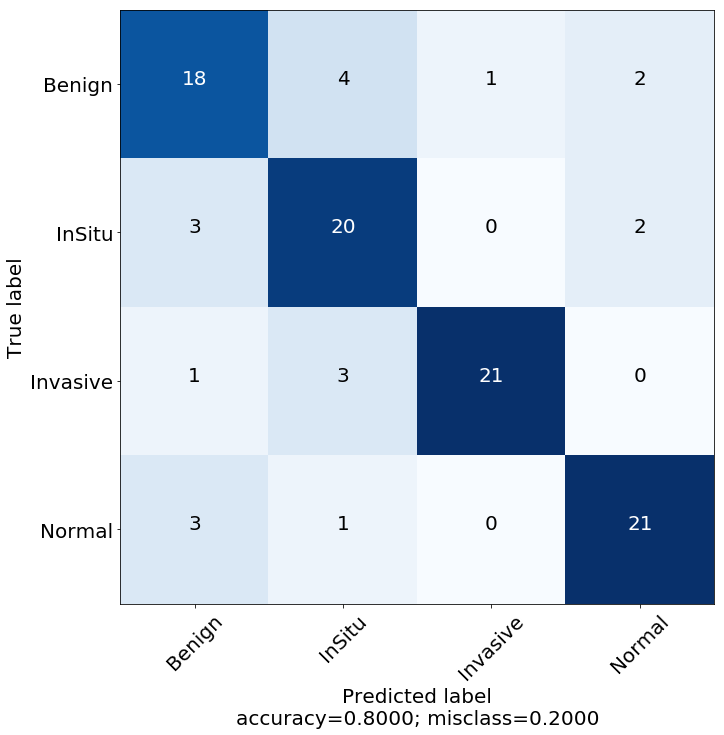

In [19]:
plt.rcParams["axes.grid"] = False
plt.rcParams.update({'font.size': 20})

labels = []

label = test_generator.class_indices
indexlabel = dict((value, key) for key, value in label.items())

for k,v in indexlabel.items():
    labels.append(v)

from sklearn.metrics import confusion_matrix
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion Matrix')

    print(cm)
#     fig = plt.figure()
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
#     plt.title(title)
#     plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
#     plt.savefig('plots/3.InceptionV3-2-Private-DataSet-CM.png', bbox_inches='tight', dpi = 100) 


plt.figure(figsize=(10,10))
plot_confusion_matrix(cm, classes=labels, title=' ')

In [20]:
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report
y_pred=predictions
y_pred_probabilities=y_pred

# y_pred = np.argmax(y_pred,axis = 1) 
y_actual = y_true

classnames=[]
for classname in test_generator.class_indices:
    classnames.append(classname)

confusion_mtx = confusion_matrix(y_actual, y_pred) 
print(confusion_mtx)
target_names = classnames
print(classification_report(y_actual, y_pred, target_names=target_names))

[[18  4  1  2]
 [ 3 20  0  2]
 [ 1  3 21  0]
 [ 3  1  0 21]]
              precision    recall  f1-score   support

      Normal       0.72      0.72      0.72        25
      InSitu       0.71      0.80      0.75        25
    Invasive       0.95      0.84      0.89        25
      Benign       0.84      0.84      0.84        25

   micro avg       0.80      0.80      0.80       100
   macro avg       0.81      0.80      0.80       100
weighted avg       0.81      0.80      0.80       100



In [21]:
total=sum(sum(cm))

sensitivity = cm[0,0]/(cm[0,0]+cm[1,0])
print('Sensitivity : ', sensitivity*100 )

Specificity = cm[1,1]/(cm[1,1]+cm[0,1])
print('Specificity : ', Specificity*100 )

Sensitivity :  85.71428571428571
Specificity :  83.33333333333334


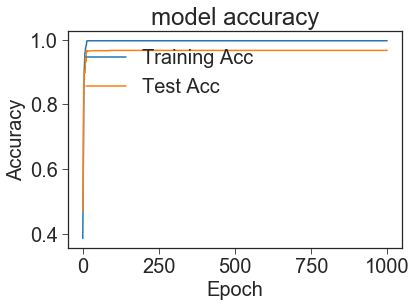

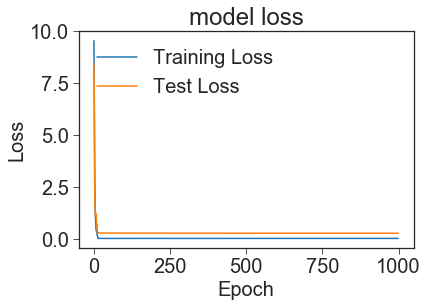

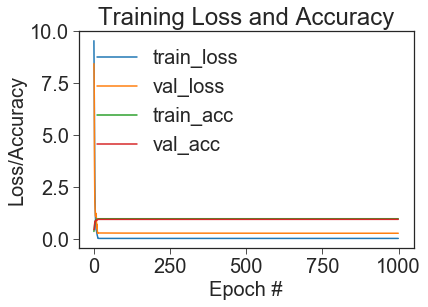

In [22]:
plt.style.use("seaborn-ticks")

plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training Acc', 'Test Acc'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training Loss', 'Test Loss'], loc='upper left')
plt.show()

plt.figure()
N = epochs
plt.plot(np.arange(0, N), history.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), history.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), history.history["acc"], label="train_acc")
plt.plot(np.arange(0, N), history.history["val_acc"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="upper left")